### Models experiment and selection for pre-campeign model.

Codes below  load the preprocessed dataset, split it into 70%, 15% and 15% for tarining, validation and test respectively.
compute class weight baseline from the training set.

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from collections import Counter
import random
import warnings
import time
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import joblib
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import shap

Codes below load the preprocessed dataset, split it into 70%, 15% and 15% for training, validation and test respectively, compute baseline class weight from the training set and the split for reuse.

In [16]:
# 1. Load dataset
df = pd.read_csv(r"C:\Users\USER\Documents\Customer Intention\df_ML1.csv")

# 2. Identify your target column name
target_col = 'y'

# 3. Split into features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# 4. Train / validation / test split (70 / 15 / 15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# 5. Compute class distribution
counter = Counter(y_train)
print("Training set class distribution:", counter)

# 6. Compute manual class weights baseline
# Weight for majority class = 1
# Weight for minority class = majority_count / minority_count
majority_class = max(counter, key=counter.get)
minority_class = min(counter, key=counter.get)

manual_weights = {
    majority_class: 1,
    minority_class: counter[majority_class] / counter[minority_class]
}

print("\n=== Define manual class weights ===")
print(manual_weights)

# Save the split datasets to disk
joblib.dump(
    (X_train, X_val, X_test, y_train, y_val, y_test),
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)

print("✅ Data splits saved successfully!")

Training set class distribution: Counter({0: 25973, 1: 2027})

=== Define manual class weights ===
{0: 1, 1: 12.813517513566847}
✅ Data splits saved successfully!


Result above shown that class weight baseline is 12.8, so values can tweak around it.

#### XGBOOST

Codes below load the saved data split, validate XGBOOST Model, tune its hyperparameters using 5-fold cv within hyperopt, use a custom scoring metric precision (40%) and recall (60%), test 30 hyperparameter configurations, experiment with class weights(7, 8, 9, 10, 12.8 and 15), auto genrate 3 random state seeds and experiment with them. Then print best class weight, seed and parameters. 

In [3]:

# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)
warnings.filterwarnings('ignore')

# 3. Hyperopt search space for XGBoost
search_space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'gamma': hp.uniform('gamma', 0.0, 1.0)
}

# 4. Seeds & Weights
NUM_SEEDS = 3
seeds = [random.randint(1000, 9999) for _ in range(NUM_SEEDS)]
manual_weights = [7, 8, 9, 10, 12.8, 15]  # similar to class weights

print(f"Generated seeds: {seeds}")

TRIALS_PER_COMBINATION = 30
CV_FOLDS = 5

# 5. Weighted precision-recall tradeoff (UPDATED)

PRECISION_WEIGHT = 0.4   
RECALL_WEIGHT = 0.6      

results = []
start_all = time.time()

# 6. Main Tuning Loop
for seed in seeds:
    for weight in manual_weights:
        print(f"\n--- TUNING: seed={seed} | scale_pos_weight={weight} | trials={TRIALS_PER_COMBINATION} ---")
        start = time.time()

        def objective(params):
            clf = XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
                random_state=seed,
                scale_pos_weight=weight,
                use_label_encoder=False,
                n_jobs=-1,
                **params
            )

            skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=seed)
            y_pred = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')

            precision = precision_score(y_train, y_pred, zero_division=0)
            recall = recall_score(y_train, y_pred, zero_division=0)
            combined_score = PRECISION_WEIGHT * precision + RECALL_WEIGHT * recall

            return {
                'loss': -combined_score,
                'status': STATUS_OK,
                'precision': precision,
                'recall': recall
            }

        trials = Trials()
        best = fmin(
            fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=TRIALS_PER_COMBINATION,
            trials=trials,
            rstate=np.random.default_rng(seed)
        )

        # Decode best params
        best_params = space_eval(search_space, best)
        best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
        best_prec = best_trial['result']['precision']
        best_rec = best_trial['result']['recall']
        best_combined = PRECISION_WEIGHT * best_prec + RECALL_WEIGHT * best_rec

        results.append((seed, weight, best_prec, best_rec, best_combined, best_params))
        end = time.time()

        print(f"Done seed={seed} weight={weight} | "
              f"Precision={best_prec:.4f} | Recall={best_rec:.4f} | Combined={best_combined:.4f} | "
              f"time={end-start:.1f}s | best params={best_params}")

end_all = time.time()
elapsed_min = (end_all - start_all)/60
print(f"\nAll tuning complete in {elapsed_min:.2f} minutes")

# 7. Summary of all combinations

print("\nSummary of all combinations:")
for (seed, weight, precision, recall, combined, params) in results:
    print(f"Seed={seed} | Weight={weight} | Precision={precision:.4f} | Recall={recall:.4f} | Combined={combined:.4f}")

# 8. Print overall best combo
best_overall = max(results, key=lambda x: x[4])  # based on combined score
print("\n=== BEST OVERALL COMBINATION (40% Precision, 60% Recall) ===")
print(f"Seed={best_overall[0]} | Weight={best_overall[1]} | "
      f"Precision={best_overall[2]:.4f} | Recall={best_overall[3]:.4f} | "
      f"Combined={best_overall[4]:.4f}")
print(f"Best Params: {best_overall[5]}")

Shapes -> Train: (28000, 23), Val: (6000, 23), Test: (6000, 23)
Generated seeds: [2746, 8221, 8723]

--- TUNING: seed=2746 | scale_pos_weight=7 | trials=30 ---
100%|██████████████████████████████████████████████| 30/30 [01:50<00:00,  3.69s/trial, best loss: -0.16885908622283066]
Done seed=2746 weight=7 | Precision=0.1239 | Recall=0.1988 | Combined=0.1689 | time=110.8s | best params={'colsample_bytree': 0.9601218168430237, 'gamma': 0.36026135232927575, 'learning_rate': 0.15017038893973886, 'max_depth': np.int64(4), 'min_child_weight': 8.87308655745384, 'n_estimators': 500, 'subsample': 0.7270910220951191}

--- TUNING: seed=2746 | scale_pos_weight=8 | trials=30 ---
100%|██████████████████████████████████████████████| 30/30 [01:57<00:00,  3.92s/trial, best loss: -0.18649295236824015]
Done seed=2746 weight=8 | Precision=0.1199 | Recall=0.2309 | Combined=0.1865 | time=117.6s | best params={'colsample_bytree': 0.86702004940786, 'gamma': 0.2699672175594621, 'learning_rate': 0.1484951623080297

Results above shown that seed(8723) and class weight(15) achieved the best params combo.

#### XGBOOST Training
Codes below load the saved data split, train XGBOOST with the best params using the seed and the class weight.

In [9]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_MLL1.pkl"
)
best_params = {
    'colsample_bytree': 0.9456803793780307,
    'gamma': 0.19734770416642672,
    'learning_rate': 0.010169526701291925,
    'max_depth': 3,
    'min_child_weight': 6.060317955176608,
    'n_estimators': 100,
    'subsample': 0.9995617754880385
}

scale_pos_weight = 15
seed = 8723

final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=seed,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    **best_params
)
final_model.fit(X_train, y_train)
print("✅ Model trained successfully.")

✅ Model trained successfully.


#### Model Evaluation
Codes below load the saved data split, evaluate the trained model using classification report, AUC and plot print its confusion matrices.


=== Train ===
Precision: 0.0848, Recall: 0.7967, AUC: 0.6197
              precision    recall  f1-score   support

           0     0.9540    0.3290    0.4892     25973
           1     0.0848    0.7967    0.1533      2027

    accuracy                         0.3628     28000
   macro avg     0.5194    0.5629    0.3213     28000
weighted avg     0.8911    0.3628    0.4649     28000


=== Validation ===
Precision: 0.0890, Recall: 0.8414, AUC: 0.6391
              precision    recall  f1-score   support

           0     0.9635    0.3270    0.4883      5565
           1     0.0890    0.8414    0.1610       435

    accuracy                         0.3643      6000
   macro avg     0.5263    0.5842    0.3247      6000
weighted avg     0.9001    0.3643    0.4646      6000


=== Test ===
Precision: 0.0865, Recall: 0.8157, AUC: 0.6217
              precision    recall  f1-score   support

           0     0.9581    0.3284    0.4892      5566
           1     0.0865    0.8157    0.1564    

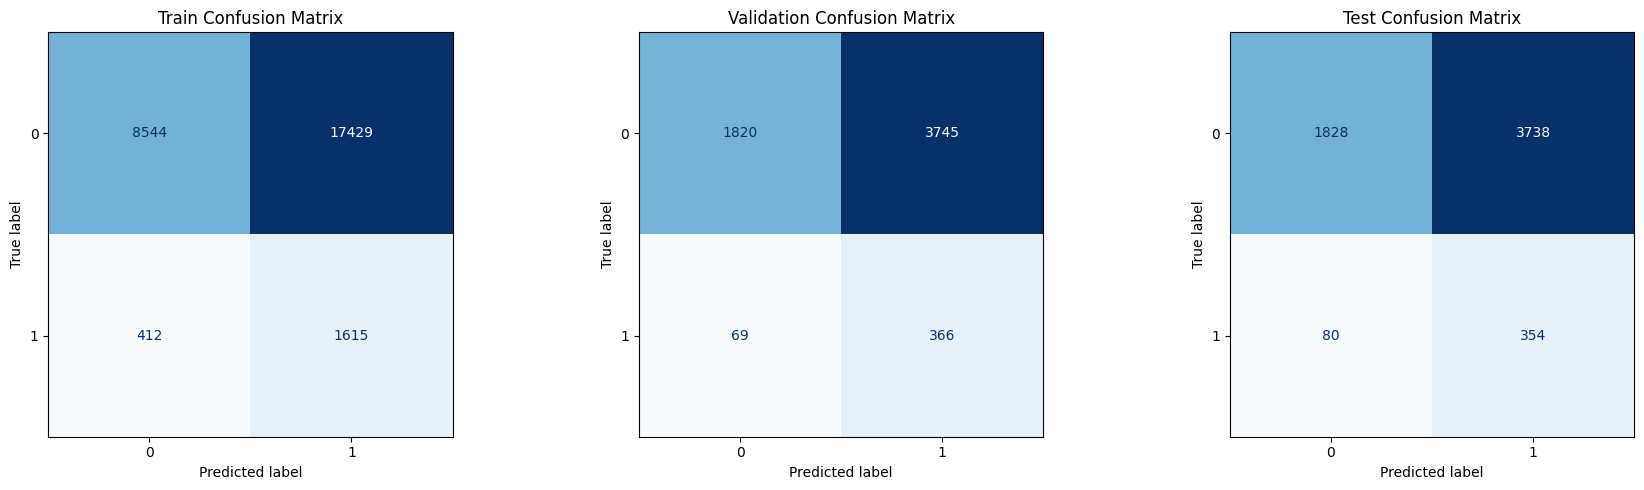

In [11]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)

from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_prob)
    report = classification_report(y, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y, y_pred)
    return prec, rec, auc, report, cm

# Evaluate across sets
sets = [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test)
]

metrics = []
for name, X_set, y_set in sets:
    prec, rec, auc, report, cm = evaluate_model(final_model, X_set, y_set)
    metrics.append((name, prec, rec, auc, report, cm))
    print(f"\n=== {name} ===")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")
    print(report)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, _, _, _, _, cm) in zip(axes, metrics):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

#### save the trained and evaluated model

In [14]:
joblib.dump(final_model, r"C:\Users\USER\Documents\Customer Intention\final_xgb_model.pkl")
print("✅ Model saved successfully to disk.")

✅ Model saved successfully to disk.


Codes below load the saved model, data split and compute its:
Total customers of the dataset.         
Number of Calls needed to make             
Number of Subscribers captured.     
Unnecessary Calls saved.             
Average call duration.    
Total time saved from calls.

In [18]:
# 1️ Load final trained model

model_path = r"C:\Users\USER\Documents\Customer Intention\final_xgb_model.pkl"
model = joblib.load(model_path)

# 2️ Load saved data splits

X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)

# Combine all splits to evaluate on the entire dataset

X_full = pd.concat([X_train, X_val, X_test], axis=0)
y_full = pd.concat([y_train, y_val, y_test], axis=0)

# 3️ Predict

y_pred = model.predict(X_full)

# 4 Confusion Matrix

cm = confusion_matrix(y_full, y_pred)
TN, FP, FN, TP = cm.ravel()

# 5️ Compute key metrics

total_customers = len(y_full)
calls_n = TP + FP               # Total calls needed
captured = TP                   # True positives
calls_saved = total_customers - calls_n
percent_calls_saved = calls_saved / total_customers * 100

# Average call duration in minutes (from dataset statistics)
avg_call_duration_min = 254.8243 / 60  # ≈ 4.25 minutes
total_time_saved_min = calls_saved * avg_call_duration_min
total_time_saved_hr = total_time_saved_min / 60


# 6️ Print model impact summary
# -------------------------------
print("MODEL IMPACT SUMMARY (ENTIRE DATASET)")
print("----------------------------------------")
print(f"Total customers:           {total_customers:,}")
print(f"Calls needed:              {calls_n:,}")
print(f"Subscribers captured:      {captured:,}")
print(f"Calls saved:               {calls_saved:,}  ({percent_calls_saved:.2f}%)")
print(f"Average call duration:     {avg_call_duration_min:.2f} minutes")
print(f"Total time saved:          {total_time_saved_min:,.0f} minutes "
      f"(~{total_time_saved_hr:,.1f} hours)")

MODEL IMPACT SUMMARY (ENTIRE DATASET)
----------------------------------------
Total customers:           40,000
Calls needed:              27,247
Subscribers captured:      2,335
Calls saved:               12,753  (31.88%)
Average call duration:     4.25 minutes
Total time saved:          54,163 minutes (~902.7 hours)


## LGBM

Codes below load the saved data split, validate LightGBM Model, tune its hyperparameters using 5-fold cv within hyperopt, use a custom scoring metric precision (40%) and recall (60%), test 30 hyperparameter configurations, experiment with class weights(7, 8, 9, 10, 12.8 and 15), auto genrate 3 random state seeds and experiment with them. Then print best class weight, seed and parameters. 

In [1]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)
# Suppress all Python warnings
warnings.filterwarnings('ignore')

# 3. Hyperopt search space for LightGBM

search_space = {
    'num_leaves': hp.choice('num_leaves', np.arange(20, 150, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_samples': hp.uniform('min_child_samples', 5, 50),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500])
}

# 4. Seeds & Weights

NUM_SEEDS = 3
seeds = [random.randint(1000, 9999) for _ in range(NUM_SEEDS)]
manual_weights = [7, 8, 9, 10, 12.8, 15]

print(f"Generated seeds: {seeds}")

TRIALS_PER_COMBINATION = 30
CV_FOLDS = 5

# 5. Weighted precision-recall tradeoff

PRECISION_WEIGHT = 0.4   # 40% precision
RECALL_WEIGHT = 0.6      # 60% recall

results = []
start_all = time.time()

# 6. Main Tuning Loop

for seed in seeds:
    for weight in manual_weights:
        print(f"\n--- TUNING: seed={seed} | scale_pos_weight={weight} | trials={TRIALS_PER_COMBINATION} ---")
        start = time.time()

        def objective(params):
            # Cast integer parameters properly
            params['min_child_samples'] = int(params['min_child_samples'])
            params['num_leaves'] = int(params['num_leaves'])
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])

            clf = lgb.LGBMClassifier(
                objective='binary',
                random_state=seed,
                scale_pos_weight=weight,
                n_jobs=-1,
                verbosity=-1,  # suppress LightGBM training warnings
                **params
            )

            skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=seed)
            y_pred = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')

            precision = precision_score(y_train, y_pred, zero_division=0)
            recall = recall_score(y_train, y_pred, zero_division=0)
            combined_score = PRECISION_WEIGHT * precision + RECALL_WEIGHT * recall

            return {
                'loss': -combined_score,
                'status': STATUS_OK,
                'precision': precision,
                'recall': recall
            }

        trials = Trials()
        best = fmin(
            fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=TRIALS_PER_COMBINATION,
            trials=trials,
            rstate=np.random.default_rng(seed)
        )

        best_params = space_eval(search_space, best)
        best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
        best_prec = best_trial['result']['precision']
        best_rec = best_trial['result']['recall']
        best_combined = PRECISION_WEIGHT * best_prec + RECALL_WEIGHT * best_rec

        results.append((seed, weight, best_prec, best_rec, best_combined, best_params))
        end = time.time()

        print(f"Done seed={seed} weight={weight} | "
              f"Precision={best_prec:.4f} | Recall={best_rec:.4f} | Combined={best_combined:.4f} | "
              f"time={end-start:.1f}s | best params={best_params}")

end_all = time.time()
elapsed_min = (end_all - start_all)/60
print(f"\nAll tuning complete in {elapsed_min:.2f} minutes")


# 7. Summary of all combinations

print("\nSummary of all combinations:")
for (seed, weight, precision, recall, combined, params) in results:
    print(f"Seed={seed} | Weight={weight} | Precision={precision:.4f} | Recall={recall:.4f} | Combined={combined:.4f}")

# 8. Print overall best combo

best_overall = max(results, key=lambda x: x[4])  # based on combined score
print("\n=== BEST OVERALL COMBINATION (40% Precision, 60% Recall) ===")
print(f"Seed={best_overall[0]} | Weight={best_overall[1]} | "
      f"Precision={best_overall[2]:.4f} | Recall={best_overall[3]:.4f} | "
      f"Combined={best_overall[4]:.4f}")
print(f"Best Params: {best_overall[5]}")

Shapes -> Train: (28000, 23), Val: (6000, 23), Test: (6000, 23)
Generated seeds: [2779, 3878, 8055]

--- TUNING: seed=2779 | scale_pos_weight=7 | trials=30 ---
100%|██████████████████████████████████████████████| 30/30 [01:22<00:00,  2.74s/trial, best loss: -0.16900833517989422]
Done seed=2779 weight=7 | Precision=0.1191 | Recall=0.2023 | Combined=0.1690 | time=82.1s | best params={'colsample_bytree': 0.7446723279797733, 'learning_rate': 0.16263017361228094, 'max_depth': np.int64(6), 'min_child_samples': 23.631243459159354, 'n_estimators': 500, 'num_leaves': np.int64(87), 'reg_alpha': 0.11532478519285047, 'reg_lambda': 0.5575985582810439, 'subsample': 0.8756566327449418}

--- TUNING: seed=2779 | scale_pos_weight=8 | trials=30 ---
100%|██████████████████████████████████████████████| 30/30 [01:38<00:00,  3.28s/trial, best loss: -0.19073875692147005]
Done seed=2779 weight=8 | Precision=0.1157 | Recall=0.2407 | Combined=0.1907 | time=98.5s | best params={'colsample_bytree': 0.8791014591853

Result above shown that see(2779) and class weight(15) peroduced best params combo.

#### Train LGBM 
Codes below load the saved data split, train LGBM model with the best params using the slected seed and the class weight.

In [26]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)

#  Define best parameters from tuning (LightGBM)

best_params = {
    'colsample_bytree': 0.6143200307201666,
    'learning_rate': 0.01716037805180485,
    'max_depth': int(3),
    'min_child_samples': int(48.88508540067273),
    'n_estimators': int(300),
    'num_leaves': int(79),
    'reg_alpha': 0.023943970317969243,
    'reg_lambda': 0.3824808510153559,
    'subsample': 0.8270100891745837
}

scale_pos_weight = 15
seed = 2779


# 4. Train final LightGBM model

final_model = lgb.LGBMClassifier(
    objective='binary',
    random_state=seed,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    verbosity=-1,  # suppress LightGBM warnings
    **best_params
)

final_model.fit(X_train, y_train)
print("model trained successfully")

model trained successfully


#### Evaluate the traind LGBM
Codes below load the saved data split, evaluate the trained lgbm using classification report, auc and plot its confusion matries.


=== Train ===
Precision: 0.0936, Recall: 0.7065, AUC: 0.6335
              precision    recall  f1-score   support

           0     0.9532    0.4663    0.6262     25973
           1     0.0936    0.7065    0.1653      2027

    accuracy                         0.4836     28000
   macro avg     0.5234    0.5864    0.3958     28000
weighted avg     0.8909    0.4836    0.5928     28000


=== Validation ===
Precision: 0.0940, Recall: 0.7103, AUC: 0.6447
              precision    recall  f1-score   support

           0     0.9536    0.4650    0.6252      5565
           1     0.0940    0.7103    0.1661       435

    accuracy                         0.4828      6000
   macro avg     0.5238    0.5877    0.3956      6000
weighted avg     0.8913    0.4828    0.5919      6000


=== Test ===
Precision: 0.0926, Recall: 0.6935, AUC: 0.6265
              precision    recall  f1-score   support

           0     0.9516    0.4702    0.6294      5566
           1     0.0926    0.6935    0.1634    

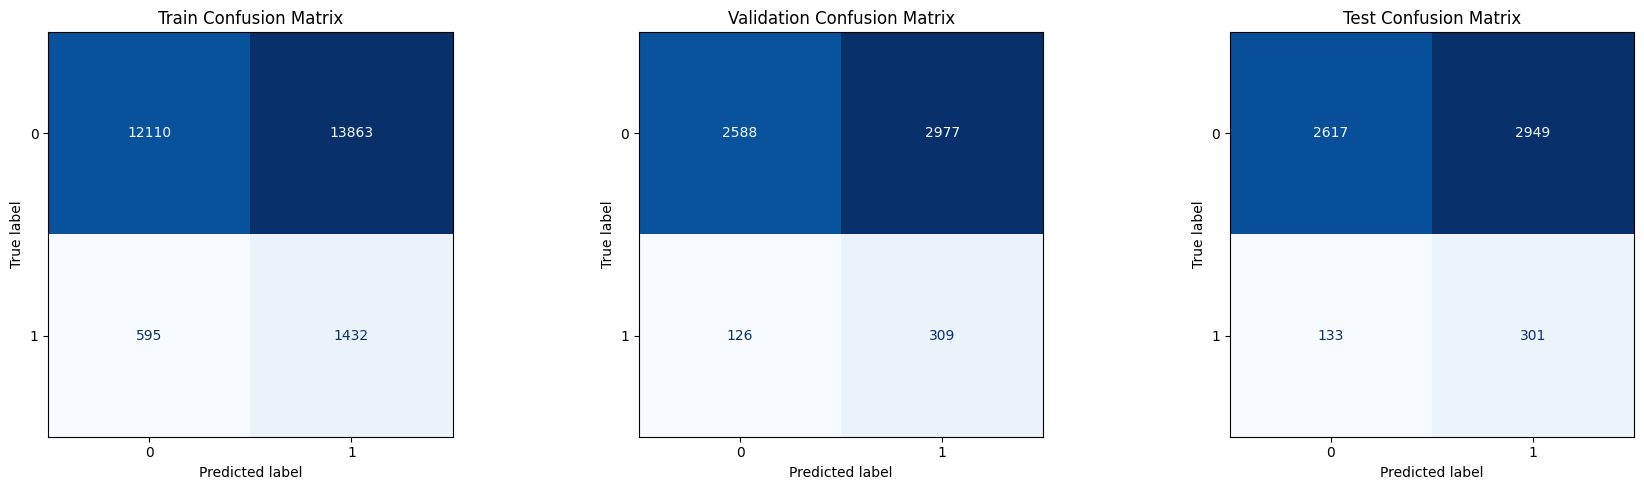

In [28]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)

# -------------------------
# 5. Evaluate model
# -------------------------
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # for AUC

    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_prob)
    report = classification_report(y, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y, y_pred)

    return prec, rec, auc, report, cm


sets = [('Train', X_train, y_train),
        ('Validation', X_val, y_val),
        ('Test', X_test, y_test)]

metrics = []
for name, X_set, y_set in sets:
    prec, rec, auc, report, cm = evaluate_model(final_model, X_set, y_set)
    metrics.append((name, prec, rec, auc, report, cm))
    print(f"\n=== {name} ===")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")
    print(report)

# -------------------------
# 6. Plot confusion matrices
# -------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, _, _, _, _, cm) in zip(axes, metrics):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

#### Save the trained and evaluated lgbm.

In [30]:
# Save your trained model
joblib.dump(final_model, r"C:\Users\USER\Documents\Customer Intention\final_lgb_model.pkl")

print("✅ Model saved successfully to disk.")

✅ Model saved successfully to disk.


Codes below load the data split, the saved model and compute its:
Total customers of the dataset.         
Number of Calls needed to make             
Number of Subscribers captured.     
Unnecessary Calls saved.             
Average call duration.    
Total time saved from calls.
by the model.

In [32]:
# 1️ Load the saved model

model_path = r"C:\Users\USER\Documents\Customer Intention\final_lgb_model.pkl"
model = joblib.load(model_path)

# 2️ Load saved data splits

X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)

# Combine all splits to evaluate on the entire dataset

X_full = pd.concat([X_train, X_val, X_test], axis=0)
y_full = pd.concat([y_train, y_val, y_test], axis=0)

# 3️ Predict

y_pred = model.predict(X_full)

# 4 Confusion Matrix

cm = confusion_matrix(y_full, y_pred)
TN, FP, FN, TP = cm.ravel()

# 5️ Compute key metrics

total_customers = len(y_full)
calls_n = TP + FP               # Total calls needed
captured = TP                   # True positives
calls_saved = total_customers - calls_n
percent_calls_saved = calls_saved / total_customers * 100

# Average call duration in minutes (from dataset statistics)
avg_call_duration_min = 254.8243 / 60  # ≈ 4.25 minutes
total_time_saved_min = calls_saved * avg_call_duration_min
total_time_saved_hr = total_time_saved_min / 60


# 6️ Print model impact summary
# -------------------------------
print("MODEL IMPACT SUMMARY (ENTIRE DATASET)")
print("----------------------------------------")
print(f"Total customers:           {total_customers:,}")
print(f"Calls needed:              {calls_n:,}")
print(f"Subscribers captured:      {captured:,}")
print(f"Calls saved:               {calls_saved:,}  ({percent_calls_saved:.2f}%)")
print(f"Average call duration:     {avg_call_duration_min:.2f} minutes")
print(f"Total time saved:          {total_time_saved_min:,.0f} minutes "
      f"(~{total_time_saved_hr:,.1f} hours)")

MODEL IMPACT SUMMARY (ENTIRE DATASET)
----------------------------------------
Total customers:           40,000
Calls needed:              21,831
Subscribers captured:      2,042
Calls saved:               18,169  (45.42%)
Average call duration:     4.25 minutes
Total time saved:          77,165 minutes (~1,286.1 hours)


## RANDOM FOREST

Codes below load the saved data split, validate Random Forest Model, tune its hyperparameters using 5-fold cv within hyperopt, use a custom scoring metric precision (40%) and recall (60%), test 30 hyperparameter configurations, experiment with class weights(7, 8, 9, 10, 12.8 and 15), auto genrate 3 random state seeds and experiment with them. Then print best class weight, seed and parameters. 

In [8]:


# 1. Load saved data splits

X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)
# -------------------------
#  Hyperopt search space for Random Forest
# -------------------------
search_space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', np.arange(3, 21, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 21, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 21, dtype=int)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

warnings.filterwarnings('ignore')

# -------------------------
# 2. Seeds & Weights
# -------------------------
NUM_SEEDS = 3
seeds = [random.randint(1000, 9999) for _ in range(NUM_SEEDS)]
manual_weights = [7, 8, 9, 10, 12.8, 15]

print(f"Generated seeds: {seeds}")

TRIALS_PER_COMBINATION = 30
CV_FOLDS = 5

# -------------------------
# 3. Weighted precision-recall tradeoff (UPDATED)
# -------------------------
PRECISION_WEIGHT = 0.4   # now 40% precision
RECALL_WEIGHT = 0.6      # now 60% recall

results = []
start_all = time.time()

# -------------------------
# 4.  Main Tuning Loop
# -------------------------
for seed in seeds:
    for weight in manual_weights:
        print(f"\n--- TUNING: seed={seed} | weight={weight} | trials={TRIALS_PER_COMBINATION} ---")
        start = time.time()

        def objective(params):
            clf = RandomForestClassifier(
                class_weight={0: 1, 1: weight},
                random_state=seed,
                n_jobs=-1,
                **params
            )

            skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=seed)
            y_pred = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')

            precision = precision_score(y_train, y_pred, zero_division=0)
            recall = recall_score(y_train, y_pred, zero_division=0)
            combined_score = PRECISION_WEIGHT * precision + RECALL_WEIGHT * recall

            return {
                'loss': -combined_score,
                'status': STATUS_OK,
                'precision': precision,
                'recall': recall
            }

        trials = Trials()
        best = fmin(
            fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=TRIALS_PER_COMBINATION,
            trials=trials,
            rstate=np.random.default_rng(seed)
        )

        # Decode best params
        best_params = space_eval(search_space, best)
        best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
        best_prec = best_trial['result']['precision']
        best_rec = best_trial['result']['recall']
        best_combined = PRECISION_WEIGHT * best_prec + RECALL_WEIGHT * best_rec

        results.append((seed, weight, best_prec, best_rec, best_combined, best_params))
        end = time.time()

        print(f"Done seed={seed} weight={weight} | "
              f"Precision={best_prec:.4f} | Recall={best_rec:.4f} | Combined={best_combined:.4f} | "
              f"time={end-start:.1f}s | best params={best_params}")

end_all = time.time()
elapsed_min = (end_all - start_all)/60
print(f"\nAll tuning complete in {elapsed_min:.2f} minutes")

# -------------------------
# 5. Summary of all combinations
# -------------------------
print("\nSummary of all combinations:")
for (seed, weight, precision, recall, combined, params) in results:
    print(f"Seed={seed} | Weight={weight} | Precision={precision:.4f} | Recall={recall:.4f} | Combined={combined:.4f}")

# -------------------------
# 6. Print overall best combo
# -------------------------
best_overall = max(results, key=lambda x: x[4])  # based on combined score
print("\n=== BEST OVERALL COMBINATION (40% Precision, 60% Recall) ===")
print(f"Seed={best_overall[0]} | Weight={best_overall[1]} | "
      f"Precision={best_overall[2]:.4f} | Recall={best_overall[3]:.4f} | "
      f"Combined={best_overall[4]:.4f}")
print(f"Best Params: {best_overall[5]}")

Shapes -> Train: (28000, 23), Val: (6000, 23), Test: (6000, 23)
Generated seeds: [1992, 9202, 7422]

--- TUNING: seed=1992 | weight=7 | trials=30 ---
100%|██████████████████████████████████████████████| 30/30 [03:43<00:00,  7.44s/trial, best loss: -0.18885427678718256]
Done seed=1992 weight=7 | Precision=0.4381 | Recall=0.0227 | Combined=0.1889 | time=223.2s | best params={'max_depth': np.int64(4), 'max_features': 'sqrt', 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(5), 'n_estimators': 400}

--- TUNING: seed=1992 | weight=8 | trials=30 ---
100%|██████████████████████████████████████████████| 30/30 [04:06<00:00,  8.20s/trial, best loss: -0.17403446331665376]
Done seed=1992 weight=8 | Precision=0.4018 | Recall=0.0222 | Combined=0.1740 | time=246.1s | best params={'max_depth': np.int64(3), 'max_features': 'log2', 'min_samples_leaf': np.int64(10), 'min_samples_split': np.int64(11), 'n_estimators': 300}

--- TUNING: seed=1992 | weight=9 | trials=30 ---
100%|███████████████

Result above shown that see(1992) and class weight(15) peroduced best params combo.

#### Train Random Forest 
Codes below load the saved data split, train RF model with the best params using the selected seed and the class weight.

In [38]:
# 1. Load saved data splits

X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)
# -------------------------
# 2. Define best parameters for Random Forest with class_weight
# -------------------------
best_params = {
    'max_depth': int(3),
    'max_features': 'sqrt',
    'min_samples_leaf': int(13),
    'min_samples_split': int(18),
    'n_estimators': 100,
    'random_state': 1992,
    'n_jobs': -1,
    'class_weight': {0: 1, 1: 15}  # handle class imbalance
}

# -------------------------
# 3. Train final Random Forest model
# -------------------------
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)

print("model trained successfully")

model trained successfully


#### Evaluate the trained Random Forest
Codes below load the saved data split, evaluate it using classification report, AUC and lot and print its confusion matrices.


=== Train ===
Precision: 0.0835, Recall: 0.8323, AUC: 0.6171
              precision    recall  f1-score   support

           0     0.9564    0.2870    0.4415     25973
           1     0.0835    0.8323    0.1518      2027

    accuracy                         0.3265     28000
   macro avg     0.5199    0.5596    0.2966     28000
weighted avg     0.8932    0.3265    0.4205     28000


=== Validation ===
Precision: 0.0874, Recall: 0.8851, AUC: 0.6448
              precision    recall  f1-score   support

           0     0.9687    0.2778    0.4318      5565
           1     0.0874    0.8851    0.1591       435

    accuracy                         0.3218      6000
   macro avg     0.5280    0.5814    0.2955      6000
weighted avg     0.9048    0.3218    0.4120      6000


=== Test ===
Precision: 0.0860, Recall: 0.8502, AUC: 0.6281
              precision    recall  f1-score   support

           0     0.9619    0.2952    0.4517      5566
           1     0.0860    0.8502    0.1562    

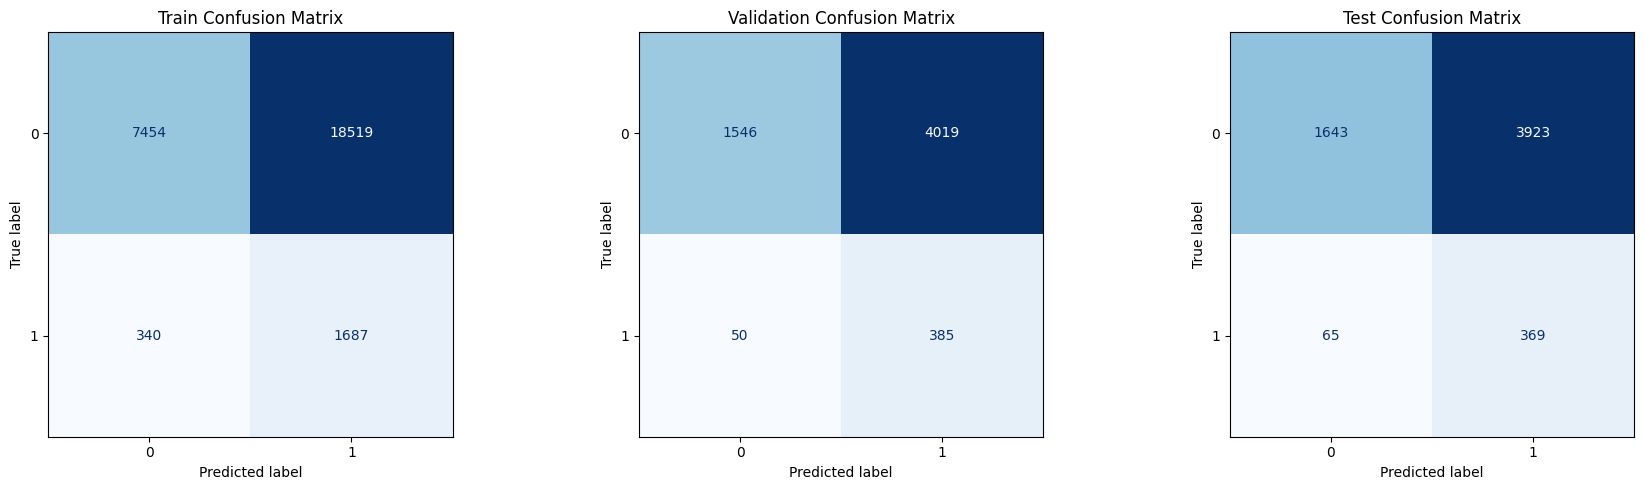

In [40]:
# 1. Load saved data splits

X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)
# -------------------------
# 5. Evaluate model
# -------------------------
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # for AUC

    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_prob)
    report = classification_report(y, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y, y_pred)

    return prec, rec, auc, report, cm


sets = [('Train', X_train, y_train),
        ('Validation', X_val, y_val),
        ('Test', X_test, y_test)]

metrics = []
for name, X_set, y_set in sets:
    prec, rec, auc, report, cm = evaluate_model(final_model, X_set, y_set)
    metrics.append((name, prec, rec, auc, report, cm))
    print(f"\n=== {name} ===")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")
    print(report)

# -------------------------
# 6. Plot confusion matrices
# -------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, _, _, _, _, cm) in zip(axes, metrics):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()



#### Save the trained and evaluated RF for reuse.

In [42]:
# Save your trained model
joblib.dump(final_model, r"C:\Users\USER\Documents\Customer Intention\final_rf_model.pkl")

print("✅ Model saved successfully to disk.")

✅ Model saved successfully to disk.


Codes below load the saved data split, traind RF and compute its:
Total customers of the dataset.         
Number of Calls needed to make             
Number of Subscribers captured.     
Unnecessary Calls saved.             
Average call duration.    
Total time saved from calls.

In [44]:
# 1️ Load the saved model

model_path = r"C:\Users\USER\Documents\Customer Intention\final_rf_model.pkl"
model = joblib.load(model_path)

# 2️ Load saved data splits

X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_ML1.pkl"
)

# Combine all splits to evaluate on the entire dataset

X_full = pd.concat([X_train, X_val, X_test], axis=0)
y_full = pd.concat([y_train, y_val, y_test], axis=0)

# 3️ Predict

y_pred = model.predict(X_full)

# 4 Confusion Matrix

cm = confusion_matrix(y_full, y_pred)
TN, FP, FN, TP = cm.ravel()

# 5️ Compute key metrics

total_customers = len(y_full)
calls_n = TP + FP               # Total calls needed
captured = TP                   # True positives
calls_saved = total_customers - calls_n
percent_calls_saved = calls_saved / total_customers * 100

# Average call duration in minutes (from dataset statistics)
avg_call_duration_min = 254.8243 / 60  # ≈ 4.25 minutes
total_time_saved_min = calls_saved * avg_call_duration_min
total_time_saved_hr = total_time_saved_min / 60


# 6️ Print model impact summary
# -------------------------------
print("MODEL IMPACT SUMMARY (ENTIRE DATASET)")
print("----------------------------------------")
print(f"Total customers:           {total_customers:,}")
print(f"Calls needed:              {calls_n:,}")
print(f"Subscribers captured:      {captured:,}")
print(f"Calls saved:               {calls_saved:,}  ({percent_calls_saved:.2f}%)")
print(f"Average call duration:     {avg_call_duration_min:.2f} minutes")
print(f"Total time saved:          {total_time_saved_min:,.0f} minutes "
      f"(~{total_time_saved_hr:,.1f} hours)")

MODEL IMPACT SUMMARY (ENTIRE DATASET)
----------------------------------------
Total customers:           40,000
Calls needed:              28,902
Subscribers captured:      2,441
Calls saved:               11,098  (27.74%)
Average call duration:     4.25 minutes
Total time saved:          47,134 minutes (~785.6 hours)


#### Summary of the models results.

**40,000: 2,896| 7.2%**

##### FOR XGB WITH :
**RECALL = 81.57%  AND PRECISION = 8.65%**
 Total customers:           40,000
Calls needed:              27,247
Subscribers captured:      2,335
Calls saved:               12,753  (31.88%)
Average call duration:     4.25 minutes
Total time saved:          54,163 minutes (~902.7 hours)
##### FOR LGB WITH :
**RECALL = 69.35%   AND PRECISION= 9.26%**
 Total customers:           40,000
Calls needed:              21,831
Subscribers captured:      2,042
Calls saved:               18,169  (45.42%)
Average call duration:     4.25 minutes
Total time saved:          77.165 minutes (~1,286.1 hours)    
##### FOR RANDOM FOREST WITH: 
**RECALL = 85.02% AND PRECISION = 8.60%**
 Total customers:           40,000
Calls needed:              28,902
Subscribers captured:      2,441
Calls saved:               11,098 (27.74%)
Average call duration:     4.25 minutes
Total time saved:          47,134 minutes (~785.6 hours)                                                   
                                             

Since **LightGBM** achieved efficeint of 9.26% and  still captured 69.35 real subscribers, it is selected and further trained and evaluated on the full dataset for segment analysis. 

#### Feature Importance Extraction and Analysis using SHAP.

Codes below train and evaluate lgbm on the full dataset and save it for shap analysis.

In [56]:

# 1. Load the full dataset

df = pd.read_csv(r"C:\Users\USER\Documents\Customer Intention\df_shap.csv")
target_col = 'y'
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"✅ Full dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

# 2. Define best LightGBM parameters (from tuning)

best_params = {
    'colsample_bytree': 0.6143200307201666,
    'learning_rate': 0.01716037805180485,
    'max_depth': int(3),
    'min_child_samples': int(49),
    'n_estimators': int(300),
    'num_leaves': int(79),
    'reg_alpha': 0.023943970317969243,
    'reg_lambda': 0.3824808510153559,
    'subsample': 0.8270100891745837
}

scale_pos_weight = 15
seed = 2779

# 3. Train the model on the full dataset

full_model = lgb.LGBMClassifier(
    objective='binary',
    random_state=seed,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    verbosity=-1,
    **best_params
)

print("🚀 Training LightGBM on the full dataset...")
full_model.fit(X, y)
print("✅ Training complete!")

# =======================================
# 4. Evaluate on the same dataset (just for reference)
# =======================================
y_pred = full_model.predict(X)
y_prob = full_model.predict_proba(X)[:, 1]

from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix

precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
cm = confusion_matrix(y, y_pred)

print("\n📊 Model Performance on Full Dataset")
print("------------------------------------")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC:       {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# =======================================
# 5. Save the trained full model for SHAP/Feature Importance
# =======================================
save_path = r"C:\Users\USER\Documents\Customer Intention\final_lgb_full_model.pkl"
joblib.dump(full_model, save_path)

print(f"\n💾 Full LightGBM model saved successfully at:\n{save_path}")

✅ Full dataset loaded: 40000 samples, 31 features
🚀 Training LightGBM on the full dataset...
✅ Training complete!

📊 Model Performance on Full Dataset
------------------------------------
Precision: 0.0936
Recall:    0.7262
AUC:       0.6399
Confusion Matrix:
[[16734 20370]
 [  793  2103]]

💾 Full LightGBM model saved successfully at:
C:\Users\USER\Documents\Customer Intention\final_lgb_full_model.pkl


#### SHAP ANALYSIS

Codes below load the dataset, the trained model and compute its shap valu.

In [3]:
# -------------------------
# 0. Suppress warnings
# -------------------------
warnings.filterwarnings("ignore")  # suppress all warnings

# -------------------------
# 1. Load model and dataset
# -------------------------
model_path = r"C:\Users\USER\Documents\Customer Intention\final_lgb_full_model.pkl"
model = joblib.load(model_path)

data_path = r"C:\Users\USER\Documents\Customer Intention\df_shap.csv"
df = pd.read_csv(data_path)

target_col = 'y'
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"✅ Model and data loaded: X={X.shape}, y={y.shape}")

# -------------------------
# 2. Compute SHAP values
# -------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

print("✅ SHAP values computed successfully!")


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Model and data loaded: X=(40000, 31), y=(40000,)
✅ SHAP values computed successfully!


### Global Feature Importance (bar chart)

Codes below rank the features according to their importance.

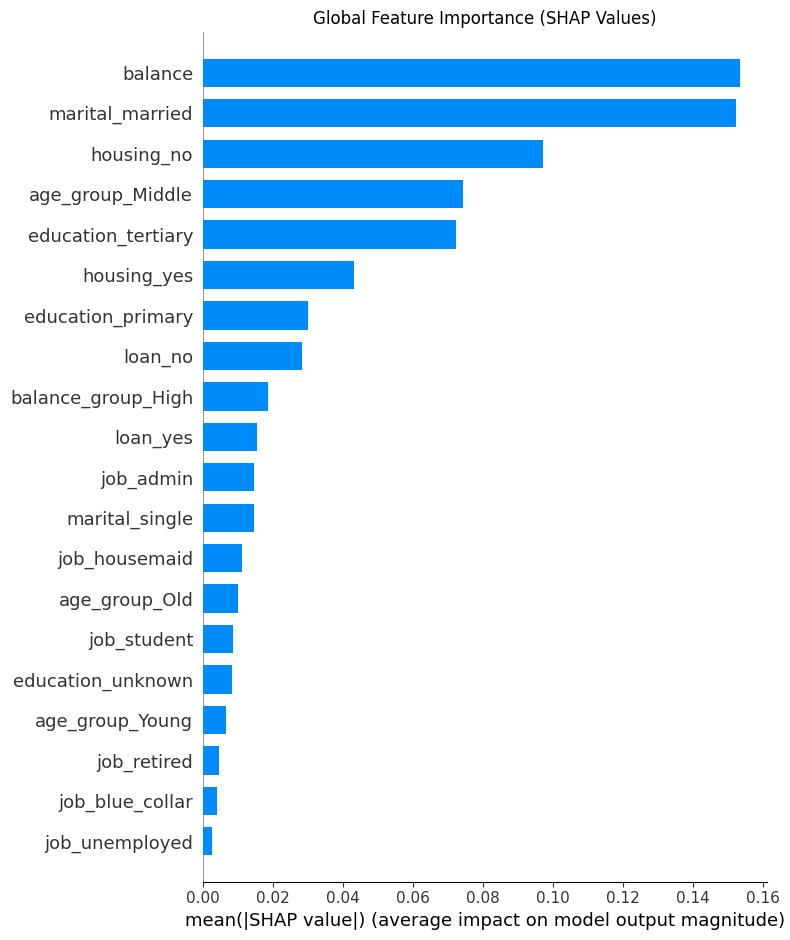

In [5]:
# Feature importance bar chart
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()

### SHAP Summary (Beeswarm plot)

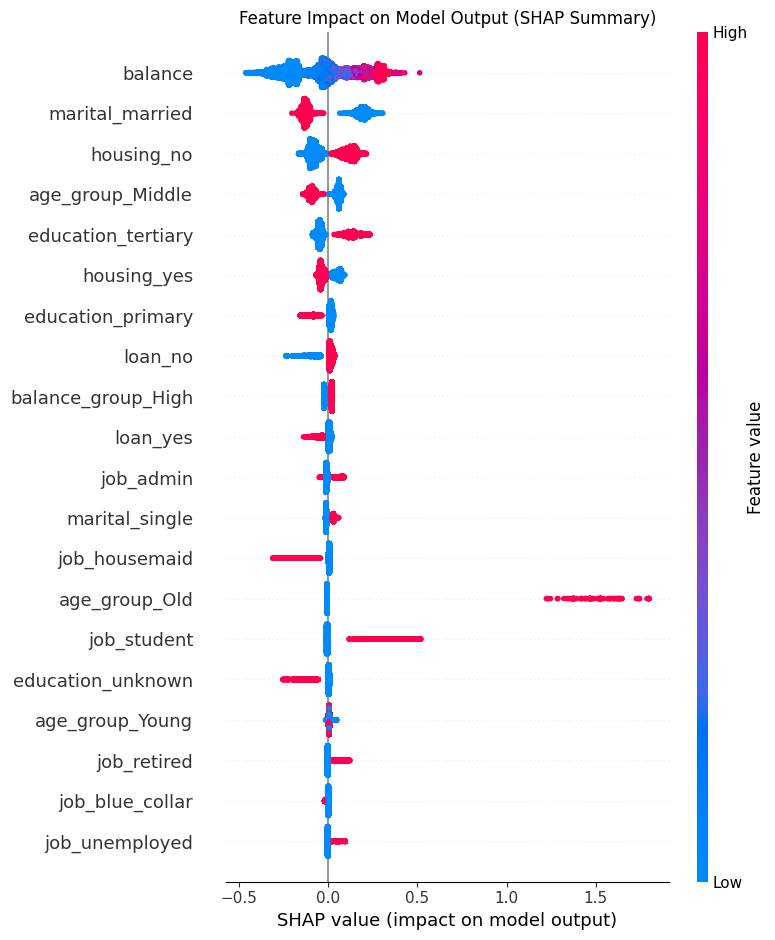

In [7]:
shap.summary_plot(shap_values, X, show=False)
plt.title("Feature Impact on Model Output (SHAP Summary)")
plt.tight_layout()
plt.show()

From the beeswarm chart above, balance, housing_no, education_ tertiary, loan_no, job_admin, age_group_old, job_student, job_retired, and job_unemployed  push the baseline probabilty up while marital_married, age_group_middle, housing_yes, loan_yes, education_primary, job_housemaid and education_unknown push the baseline probability down.
